<a href="https://colab.research.google.com/github/S3688570/Cars_Deep_Learning/blob/master/cars_act_CNN_final.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Visualizing activation for cars CNN model

In [0]:
from google.colab import drive, files
drive.mount('/content/gdrive')
gdrive_path = 'gdrive/My\ Drive/Colab\ Notebooks/'
!rsync -ah --progress\
    {gdrive_path}cars_dl/*.zip\
    {gdrive_path}model_weights.h5\
    {gdrive_path}model_structure.json\
    '/content'
!unzip -qo '*.zip'
!rm *.zip

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/gdrive
sending incremental file list
cars-20191002T050118Z-001.zip
        490.68M 100%   63.40MB/s    0:00:07 (xfr#1, to-chk=2/3)
model_structure.json
          5.33K 100%    6.06kB/s    0:00:00 (xfr#2, to-chk=1/3)
model_weights.h5
        737.50K 100%  631.77kB/s    0:00:01 (xfr#3, to-chk=0/3)


In [0]:
from keras.models import model_from_json
from pathlib import Path
from keras.preprocessing import image
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image
import os

Using TensorFlow backend.


##Load the json file that contains the model's structure

In [0]:
f = Path("model_structure.json")
model_structure = f.read_text()

## Recreate the Keras model object from the json data

In [0]:
model = model_from_json(model_structure)






Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


## Re-load the model's trained weights

In [0]:
model.load_weights("model_weights.h5")

## Summary of model

In [0]:
 model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 126, 126, 32)      896       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 63, 63, 32)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 63, 63, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 61, 61, 32)        9248      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 30, 30, 32)        0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 30, 30, 32)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 28, 28, 32)       

## Preprocessing a single image

In [0]:
from keras.preprocessing.image import ImageDataGenerator
import os

test_data_dir = 'cars/test_set/'
testCarImages = os.listdir('cars/test_set/car/')
img_path = 'cars/test_set/car/' + testCarImages[60]

test_datagen = ImageDataGenerator(rescale = 1./255)
test_set = test_datagen.flow_from_directory(test_data_dir,
                                            target_size = (128, 128),
                                            batch_size = 32,
                                            class_mode = 'categorical',
                                            shuffle=True,
                                            seed=42)

Found 260 images belonging to 2 classes.


In [0]:
# We preprocess the image into a 4D tensor
from keras.preprocessing import image
import numpy as np
img = image.load_img(img_path, target_size=(128, 128))
img_tensor = image.img_to_array(img)
img_tensor = np.expand_dims(img_tensor, axis=0)
# Remember that the model was trained on inputs
# that were preprocessed in the following way:
img_tensor /= 255.
# Its shape is (1, 128, 128, 3)
print(img_tensor.shape)

(1, 128, 128, 3)


##Displaying the test image

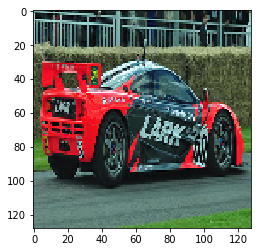

In [0]:
plt.imshow(img_tensor[0])

##Instantiating a model from an input tensor and a list of otput tensors

In [0]:
from keras import models
# Extracts the outputs of the top 12 layers:
layer_outputs = [layer.output for layer in model.layers[:2]]
# Creates a model that will return these outputs, given the model input:
activation_model = models.Model(inputs=model.input, outputs=layer_outputs)

##Prediction

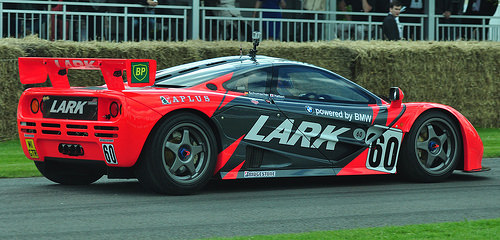

In [0]:
testCarImages = os.listdir('cars/test_set/car/')
testFilename = 'cars/test_set/car/' + testCarImages[60]

test_image = image.load_img(testFilename, target_size = (128, 128))
test_image = image.img_to_array(test_image)
test_image = np.expand_dims(test_image, axis=0)
result = model.predict(test_image)
test_set.class_indices
if result[0][0] < 0.3:
  prediction = '[0.1]'
elif result[0][0] > 0.7: 
  prediction = '[1.0]'
else:
  prediction = 'Unsure'


dimage = Image.open(testFilename)
dimage

In [0]:
print("Prediction: " + str(result[0][0]))

Prediction: 1.0


In [0]:
# This will return a list of 5 Numpy arrays: one array per layer activation
activations = activation_model.predict(img_tensor)

##First entry in the outputs: the output of the first layer of the original model



In [0]:
first_layer_activation = activations[0]
print(first_layer_activation.shape)

(1, 126, 126, 32)


##Plotting the 5th channel of the activation of the first layer of the original model

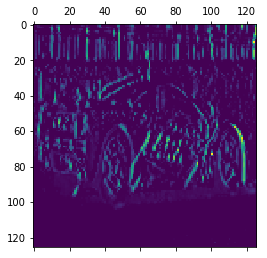

In [0]:
import matplotlib.pyplot as plt
plt.matshow(first_layer_activation[0, :, :, 5], cmap='viridis')

## Plot the 18th channel of the activation of the fisrt layer of the model

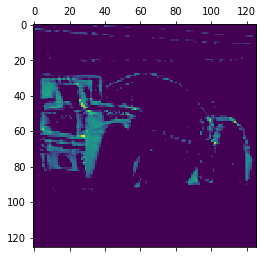

In [0]:
plt.matshow(first_layer_activation[0, :, :, 20], cmap='viridis')

## Visualizing every channel in every intermediate activation

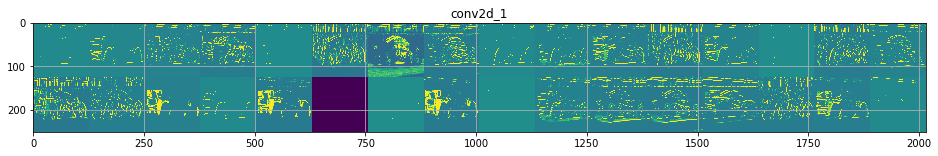

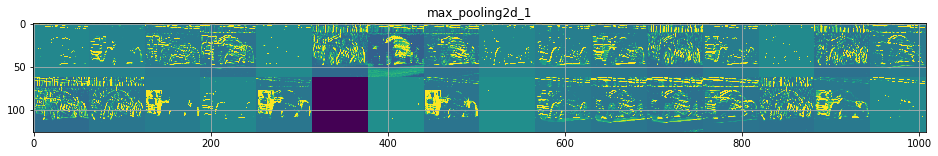

In [0]:
# Names of the layers
layer_names = []
for layer in model.layers[:8]:
  layer_names.append(layer.name)
images_per_row = 16

# Display feature maps
for layer_name, layer_activation in zip(layer_names, activations):
  # This is the number of features in the feature map
  n_features = layer_activation.shape[-1]     #32

  # The feature map has shape (1, size, size, n_features)
  size = layer_activation.shape[1]      #63

  # Tile the activation channels in this matrix
  n_cols = n_features // images_per_row   #32//16 = 2
  display_grid = np.zeros((size * n_cols, images_per_row * size))     #(63*2, 16*63) -> (126, 1008)

  # Tile each filter into this big horizontal grid
  for col in range(n_cols):
    for row in range(images_per_row):
     channel_image = layer_activation[0, :, :, col * images_per_row + row]
     # Post-process the feature to make it visually palatable
     channel_image -= channel_image.mean()
     channel_image /= channel_image.std()
     channel_image *= 64
     channel_image += 128
     channel_image = np.clip(channel_image, 0, 255).astype('uint8')
     display_grid[col * size : (col + 1) * size,
                  row * size : (row + 1) * size] = channel_image

  # Display the grid
  scale = 1. / size
  plt.figure(figsize=(scale * display_grid.shape[1],
                      scale * display_grid.shape[0]))
  plt.title(layer_name)
  plt.grid(True)
  plt.imshow(display_grid, aspect='auto', cmap='viridis')

In [0]:

print(layer_names)

['conv2d_1', 'max_pooling2d_1', 'dropout_1', 'conv2d_2', 'max_pooling2d_2', 'dropout_2', 'conv2d_3', 'max_pooling2d_3']


0.99815184
0.93519294
0.06446395
0.1979065
0.10372883
0.056397505
0.16553429


/usr/local/lib/python3.6/dist-packages/matplotlib/text.py:1191: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if s != self._text:


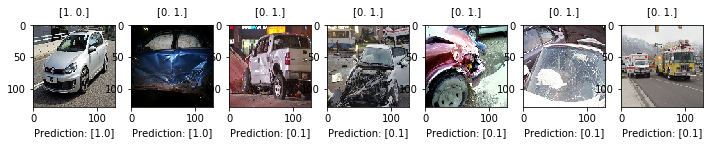

In [0]:
#Method to print several images in a single row 
def plots(img, figsize=(12,6), rows = 1, titles = 1):
  
  if type(img[0]) is np.ndarray:
    img = np.array(img).astype(np.float_)
  if (img.shape[-1] != 3):
    img = img.transpose((0, 2, 3, 1))
  f =plt.figure(figsize = figsize)
  cols = 7//rows if (len(img) % 2 == 0) else len(img)//rows + 1
  
  for i in range(cols):
    sp = f.add_subplot(rows, cols, i+1)
    sp.axis('On')
    
    result = model.predict(img)
    print(result[i][0])
    test_set.class_indices
    if result[i][0] < 0.3:
      prediction = '[0.1]'
    elif result[i][0] > 0.7: 
      prediction = '[1.0]'
    else:
      prediction = 'Unsure'

    if titles is not None:
      sp.set_title(titles[i], fontsize = 10, pad = 10)
      sp.set_xlabel('Prediction: ' + prediction)
    plt.imshow(img[i], interpolation = None if np.interp else 'none')


imgs, labels = next(test_set)
plots(imgs, titles = labels)

###Is GPU running

In [0]:
import tensorflow as tf
tf.test.gpu_device_name()

'/device:GPU:0'

###Which GPU

In [0]:
from tensorflow.python.client import device_lib
device_lib.list_local_devices()

[name: "/device:CPU:0"
 device_type: "CPU"
 memory_limit: 268435456
 locality {
 }
 incarnation: 11364175605050480289, name: "/device:XLA_CPU:0"
 device_type: "XLA_CPU"
 memory_limit: 17179869184
 locality {
 }
 incarnation: 3978199326351661895
 physical_device_desc: "device: XLA_CPU device", name: "/device:XLA_GPU:0"
 device_type: "XLA_GPU"
 memory_limit: 17179869184
 locality {
 }
 incarnation: 2189663259317027062
 physical_device_desc: "device: XLA_GPU device", name: "/device:GPU:0"
 device_type: "GPU"
 memory_limit: 11330053735
 locality {
   bus_id: 1
   links {
   }
 }
 incarnation: 16840495250850241043
 physical_device_desc: "device: 0, name: Tesla K80, pci bus id: 0000:00:04.0, compute capability: 3.7"]

###RAM info

In [0]:
!cat /proc/meminfo

MemTotal:       13335192 kB
MemFree:         5483108 kB
MemAvailable:   11538712 kB
Buffers:           74020 kB
Cached:          5913096 kB
SwapCached:            0 kB
Active:          1570732 kB
Inactive:        5836292 kB
Active(anon):    1230376 kB
Inactive(anon):     7488 kB
Active(file):     340356 kB
Inactive(file):  5828804 kB
Unevictable:           0 kB
Mlocked:               0 kB
SwapTotal:             0 kB
SwapFree:              0 kB
Dirty:              4776 kB
Writeback:             0 kB
AnonPages:       1419856 kB
Mapped:           705888 kB
Shmem:              8064 kB
Slab:             251536 kB
SReclaimable:     211900 kB
SUnreclaim:        39636 kB
KernelStack:        4480 kB
PageTables:        10688 kB
NFS_Unstable:          0 kB
Bounce:                0 kB
WritebackTmp:          0 kB
CommitLimit:     6667596 kB
Committed_AS:    4298364 kB
VmallocTotal:   34359738367 kB
VmallocUsed:           0 kB
VmallocChunk:          0 kB
AnonHugePages:     20480 kB
ShmemHugePages:  

###CPU info

In [0]:
!cat /proc/cpuinfo

processor	: 0
vendor_id	: GenuineIntel
cpu family	: 6
model		: 63
model name	: Intel(R) Xeon(R) CPU @ 2.30GHz
stepping	: 0
microcode	: 0x1
cpu MHz		: 2300.000
cache size	: 46080 KB
physical id	: 0
siblings	: 2
core id		: 0
cpu cores	: 1
apicid		: 0
initial apicid	: 0
fpu		: yes
fpu_exception	: yes
cpuid level	: 13
wp		: yes
flags		: fpu vme de pse tsc msr pae mce cx8 apic sep mtrr pge mca cmov pat pse36 clflush mmx fxsr sse sse2 ss ht syscall nx pdpe1gb rdtscp lm constant_tsc rep_good nopl xtopology nonstop_tsc cpuid tsc_known_freq pni pclmulqdq ssse3 fma cx16 pcid sse4_1 sse4_2 x2apic movbe popcnt aes xsave avx f16c rdrand hypervisor lahf_lm abm invpcid_single ssbd ibrs ibpb stibp fsgsbase tsc_adjust bmi1 avx2 smep bmi2 erms invpcid xsaveopt arat md_clear arch_capabilities
bugs		: cpu_meltdown spectre_v1 spectre_v2 spec_store_bypass l1tf mds swapgs
bogomips	: 4600.00
clflush size	: 64
cache_alignment	: 64
address sizes	: 46 bits physical, 48 bits virtual
power management:

processor	: